## Code for article "Containminated Images Recovery by Implementing Non-negative Matrix Factorisation"

## 1.0 Load Dataset



### 1.1 Set data folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Master of DS/COMP5328/Assignment/data/'

Mounted at /content/drive
/content/drive/Othercomputers/My laptop/Master of DS/COMP5328/Assignment/data


In [ ]:
# The structure of data folder.
!ls -l data

total 8
drwx------ 2 root root 4096 Sep  5 07:35 CroppedYaleB
drwx------ 2 root root 4096 Sep  5 07:38 ORL


### 1.1 Load ORL or Extended YaleB Dataset.
-   ORL dataset contains ten different images of each of 40 distinct
    subjects. For some subjects, the images were taken at different
    times, varying the lighting, facial expressions (open / closed eyes,
    smiling / not smiling) and facial details (glasses / no glasses).
    All the images were taken against a dark homogeneous background with
    the subjects in an upright, frontal position (with tolerance for
    some side movement). The size of each image is 92x112 pixels, with
    256 grey levels per pixel. To further reduce the computation
    complexity, you can resize all images to 30x37 pixels.

-   Extended YaleB dataset contains 2414 images of 38 human subjects
    under 9 poses and 64 illumination conditions. All images are
    manually aligned, cropped, and then resized to 168x192 pixels. To
    further reduce the computation complexity, you can resize all images
    to 42x48 pixels.

In [ ]:
from time import time
from matplotlib import pyplot as plt

In [ ]:
import os
import numpy as np
from PIL import Image

def load_data(root='data/CroppedYaleB', reduce=4):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            
            img = img.convert('L') # grey image. gets values between 0-255 (8-bit).

            # print(img.size) #Original image size (92, 112)

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size]) #(92//reduce, 112//reduce)

            # print(img.size)

            # TODO: preprocessing.

            # convert image to numpy array.
            image_shape = np.asarray(img).shape #Output image shape
            img = np.asarray(img).reshape((-1,1)) #Shape for img:  (92//reduce * 112//reduce, 1)

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels, image_shape

#### Load ORL dataset.

[Notice: Choose one of them to run, they cannot be run at the same time]

In [ ]:
# Load ORL dataset.
print('==> Load ORL dataset ...')
V_hat, Y_hat,image_shape = load_data(root='data/ORL', reduce=3)
print('V_hat.shape={}, Y_hat.shape={}, image size = {}'.format(V_hat.shape, Y_hat.shape,image_shape))

==> Load ORL dataset ...
V_hat.shape=(1110, 400), Y_hat.shape=(400,), image size = (37, 30)


#### Load YaleB dataset.
[Notice: Choose one of them to run, they cannot be run at the same time]

In [ ]:
# Load Extended YaleB dataset.
time_start = time()
print('==> Load YaleB dataset ...')
V_hat_YaleB, Y_hat_YaleB,image_shape_YaleB = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YalB dataset: V_hat.shape = {}, Y_hat.shape = {}, image size = {}'.format(V_hat_YaleB.shape, Y_hat_YaleB.shape,image_shape_YaleB))
time_load_YaleB = (time() - time_start)
print("YaleB data load finished in %fs"%time_load_YaleB)

==> Load YaleB dataset ...
Extended YalB dataset: V_hat.shape = (2016, 2414), Y_hat.shape = (2414,), image size = (48, 42)
YaleB data load finished in 437.852976s


In [ ]:
#If runing results for YaleB data, change the name of YaleB dataset to fit the following code
V_hat = V_hat_YaleB
Y_hat = Y_hat_YaleB
image_shape = image_shape_YaleB

## 2.0 Noise Function

The following type of noises are created:

*   Block Occlusion by b x b-blocks with b = 10,12 and 14 pixels.
*   Salt & Peper noise with p% pixels are contamined, p = 5,10,20




In [ ]:
#Image with noise function
def add_noise(image,noise_typ,amount):
  
  if noise_typ == "block":
    print("block occlusion noise b = ",amount)
    out = np.zeros(image.shape)
    for i in range(image.shape[1]):
      temp = np.copy(image)[:,i].reshape(image_shape)
      x = np.random.randint(0, image_shape[1] - amount)
      y = np.random.randint(0, image_shape[0] - amount)
      temp[y:y+amount, x:x+amount] = 255
      temp = temp.reshape((-1))
      # print(temp.shape)
      out[:,i] = temp
    return out

  elif noise_typ == "s&p":
    print("S&P noise with {}% piexels".format(amount *100))
    # Salt-and-pepper - Replace random pixels with 0 or 255. 
    # S&P noise is also called impulse noise. It can be caused by several reasons like dead pixels, analog-to-digital conversion error, bit transmission error, etc.
    # Code reference: https://discuss.dizzycoding.com/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv-duplicate/
    s_vs_p = 0.5
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) #randomly return index from 0 to image pixels for num_pepper
                  for i in image.shape]
    out[tuple(coords)] = 255
    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1 - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape] #randomly return index from 0 to image pixels for num_pepper
    out[tuple(coords)] = 0
    return out
# out_test = add_noise(V_hat,noise_typ = "block",amount = 10)
# plt.imshow(out_test[:,2].reshape(image_shape), cmap=plt.cm.gray)

In [ ]:
noise_scenario = [(V_hat,"block",10),(V_hat,"block",12),(V_hat,"block",14),(V_hat, "s&p", 0.05),(V_hat, "s&p", 0.1), (V_hat,"s&p",0.2)]
noise_scenario_name = ["block_10","block_12","block_14","s&p_5%","s&p_10%", "s&p_20%"]
V_list = []
np.random.seed(0)
for scenario in noise_scenario:
    V = add_noise(*scenario)
    V_list.append(V)
V_list.insert(0, V_hat)
noise_scenario_name = ["Origin"] + noise_scenario_name

block occlusion noise b =  10
block occlusion noise b =  12
block occlusion noise b =  14
S&P noise with 5.0% piexels
S&P noise with 10.0% piexels
S&P noise with 20.0% piexels


Figures below are examples of face with different type of noises

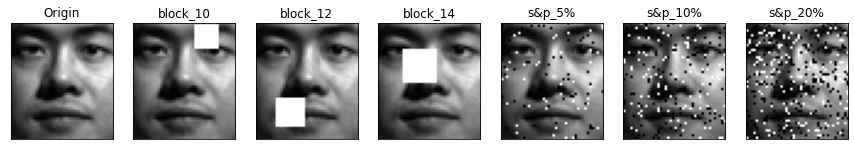

In [ ]:
plt.figure(figsize=(15,18))
for i in range(len(noise_scenario_name)):
    plt.subplot(1, len(noise_scenario_name), i+1)
    plt.imshow(V_list[i][:,100].reshape(image_shape), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())
    plt.title(noise_scenario_name[i])

## 3.0 Evaluation Metrics
### 3.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the
`relative reconstruction errors`. Let $V$ denote the contaminated
dataset (by adding noise), and $\hat{V}$ denote the clean dataset.
Let $W$ and $H$ denote the factorization results on $V$, the
`relative reconstruction errors` then can be defined as follows:
 $$ RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.  $$

### 3.2 Evaluate Clustering Performance

1.  Accuracy can be calculated as follows.
$$Acc(Y, Y_{pred}) = \frac{1}{n}\sum \limits_{i=1}^n 1\{Y_{pred}(i)==Y(i)\}.$$


2.  Normalized Mutual Information (NMI) can be calculated as follows.
$$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})}, $$
where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot)$ is entropy.


In [ ]:
#For Evaluate metrics
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

def evaluate_metrics(V_hat,Y_hat,H,W):

  # relative reconstruction errors
  rre = np.linalg.norm(V_hat - W.dot(H)) / np.linalg.norm(V_hat)

  # Assign cluster labels.
  Y_pred = assign_cluster_label(np.transpose(H), Y_hat)

  #Acc and NMI
  acc = accuracy_score(Y_hat, Y_pred)
  nmi = normalized_mutual_info_score(Y_hat, Y_pred)
  # print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))

  return rre,acc,nmi

#Testing evaluation code
# rre, acc, nmi = evaluate_metrics(V_hat = V_hat,Y_hat = Y_hat,H = H,W = W)
# print('RRE = {:.4f}, acc = {:.4f}, nmi = {:.4f}'.format(rre, acc, nmi))

## 4.0 NMF Method

### 4.1 Traditional NMF Method

In [ ]:
def mf_multiplicative_update(V, W, H, steps=5000):
    for step in range(steps):
        Wu = W*(V.dot(H))/(W.dot(H.T).dot(H))+1e-7
        Hu = (H.T*(Wu.T.dot(V))/(Wu.T.dot(Wu).dot(H.T))).T+1e-7
        
        e_W = np.sqrt(np.sum((Wu-W)**2, axis=(0,1)))/W.size   #same as lng.norm(Pu-P)/P.size -> Frobenius norm/n
        e_H = np.sqrt(np.sum((Hu-H)**2, axis=(0,1)))/H.size
        # print(e_P)
        # print(e_Q)
        if e_W<1e-5 and e_H<1e-5:
            print("step is:",step)
            break
        W = Wu
        H = Hu
    return W, H

def nmf_function(V,Y_hat,random_seed = 1):

  rng = np.random.RandomState(random_seed)
  
  N = len(V)
  M = len(V[0])
  K = len(set(Y_hat))  #set number of new dimension
  #initialise the matrix
  W = rng.rand(N,K)
  H = rng.rand(M,K)
  time_start = time()
  
  W, H_T = mf_multiplicative_update(V = V, W = W, H = H)
  H = np.transpose(H_T)
  time_training = (time() - time_start)
  print("Training finished in %fs"%time_training)
  return W,H,time_training

step is: 1004
Training finished in 60.716153s


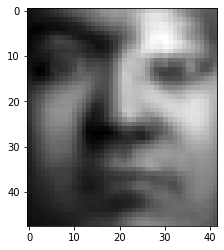

In [ ]:
#Testing NMF function code
W,H,time_training = nmf_function(V_list[1],Y_hat)
plt.imshow(W.dot(H)[:,100].reshape(image_shape), cmap=plt.cm.gray)

### 4.2 Hypersurface Cost NMF

In [ ]:
#Function to calculate the value of the matrix update, indepenent of the learning rate
def hcnmf_update(R, P, Q):
  P_new = ((
            (P.dot(Q).dot(Q.T) - (R.dot(Q.T)))
            /(np.sqrt(1+np.sum(R - (P.dot(Q)))**2))
          ))
  
  Q_new = ((
            ((P.T).dot(P).dot(Q) - ((P.T).dot(R)))
            /(np.sqrt(1+np.sum(R-(P.dot(Q)))**2))
          ))
  
  return P_new, Q_new

#Additive updating function with dynamic learning rates alpha and beta
def hcnmf_train(R, steps, alpha, beta,Y_hat,random_seed = 1): # P, Q

  #First, initialise the matrices as random, as done in the NMF function
  N = len(R)
  M = len(R[0])
  K = len(set(Y_hat))  #set number of new dimensions

  rng = np.random.RandomState(random_seed)
  P = rng.rand(N,K)
  Q = rng.rand(K,M)
  time_start = time()

  loss = [100000] 
  count = 0

  time_start = time()
  while(loss[count] > 1e-5) and (count < steps):
    P_t, Q_t = hcnmf_update(R, P=P, Q=Q) 
    P = P - (P_t * alpha)
    Q = Q - (Q_t * beta)
    l = np.sum((R-P.dot(Q))**2)
    loss.append(l)
    count+=1
  time_training = (time() - time_start)
  print("step is:",count)
  print("Training finished in %fs"%time_training)
  return P, Q, loss, count,time_training

#### HCNMF with Armijo rule **This part is only for showing Armijo rule, please do not run this part**

**[Notice: this part is yet to be verified because of very high computational complexity]**

In [ ]:
#Function to calculate the value of the matrix update, indepenent of the learning rate
def hcnmf_update(R, P, Q):
  P_new = ((
            (P.dot(Q).dot(Q.T) - (R.dot(Q.T)))
            /(np.sqrt(1+np.sum(R - (P.dot(Q)))**2))
          ))
  
  Q_new = ((
            ((P.T).dot(P).dot(Q) - ((P.T).dot(R)))
            /(np.sqrt(1+np.sum(R-(P.dot(Q)))**2))
          ))
  
  return P_new, Q_new

def armijo_check_P(P_t, step_size,alpha,R,P,Q): 
    variance =  0.5*(np.sqrt(1+np.linalg.norm(R-P.dot(Q)))-1)
    update_P = P-step_size*P_t
    update_variance = 0.5 * (np.sqrt(1 + np.linalg.norm(R - update_P @ Q)) - 1)
    if update_variance-variance <= -step_size * alpha * np.linalg.norm(P_t) ** 2:
        return True
    return False

def armijo_check_Q(Q_t, step_size,alpha,R,P,Q): 
    variance =  0.5*(np.sqrt(1+np.linalg.norm(R-P.dot(Q)))-1)
    update_Q = P-step_size*Q_t
    update_variance = 0.5 * (np.sqrt(1 + np.linalg.norm(R - P @ update_Q)) - 1)
    if update_variance-variance <= -step_size * alpha * np.linalg.norm(Q_t) ** 2:
        return True
    return False

#alpha updating rule
def alpha_update(P_t,initial_step,alpha,beta,R,P,Q):
    #Find armijo coefficient for updating P in this iteration
    step_size  = initial_step
    while not armijo_check_P(P_t, step_size,alpha,R,P,Q):
        step_size = step_size*beta
    return step_size
    
#beta updating rule
def beta_update(Q_t,initial_step,alpha,beta,R,P,Q):
    #Find armijo coefficient for updating P in this iteration
    step_size  = initial_step
    while not armijo_check_Q(Q_t, step_size,alpha,R,P,Q):
        step_size = step_size*beta
    print('4.2')
    return step_size

#Additive updating function with dynamic learning rates alpha and beta
def hcnmf_train(R, steps, alpha, beta,Y_hat,random_seed = 1): # P, Q

  #First, initialise the matrices as random, as done in the NMF function
  N = len(R)
  M = len(R[0])
  K = len(set(Y_hat))  #set number of new dimensions

  initial_alpha = 1
  initial_beta  = 1
  initial_step = 0.1

  rng = np.random.RandomState(random_seed)
  P = rng.rand(N,K)
  Q = rng.rand(K,M)
  time_start = time()

  loss = [100000] 
  count = 0

  time_start = time()
  while(count < steps):
    P_t, Q_t = hcnmf_update(R, P=P, Q=Q) 
    
    alpha = alpha_update(P_t,initial_step,alpha,beta,R,P,Q)

    P = P - (P_t * alpha)
    
    beta = beta_update(Q_t,initial_step,alpha,beta,R,P,Q)

    Q = Q - (Q_t * beta)
    l = np.sum((R-P.dot(Q))**2)
    # print(l)
    loss.append(l)
    count+=1
  time_training = (time() - time_start)
  print("Training finished in %fs"%time_training)
  return P, Q, loss, count,time_training

####Testing HCNMF performance based on different alpha and beta

step is: 3000
Training finished in 369.494880s


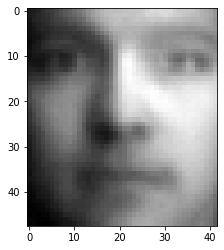

In [ ]:
#Testing Perform training
P, Q, loss,count,time_training = hcnmf_train(V_list[1], 3000, 0.8, 0.8,Y_hat,random_seed = 1)
plt.imshow(P.dot(Q)[:,100].reshape(image_shape), cmap=plt.cm.gray)

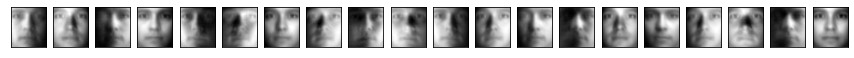

In [ ]:
plt.figure(figsize=(15,18))
for i in range(20):
    plt.subplot(1, 20, i+1)
    plt.imshow(P.dot(Q)[:,i].reshape(image_shape), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

step is: 3000
Training finished in 367.099704s


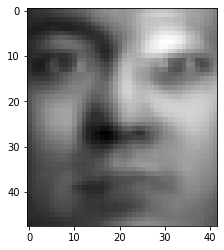

In [ ]:
#Testing Perform training
P, Q, loss,count,time_training = hcnmf_train(V_list[1], 3000, 1, 1,Y_hat,random_seed = 1)
plt.imshow(P.dot(Q)[:,100].reshape(image_shape), cmap=plt.cm.gray)

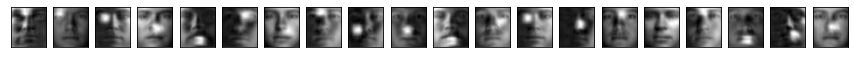

In [ ]:
plt.figure(figsize=(15,18))
for i in range(20):
    plt.subplot(1, 20, i+1)
    plt.imshow(P.dot(Q)[:,i].reshape(image_shape), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

###4.3 L2,1 NMF

In [ ]:
def l12nmf_update(V, W, H, steps=5000):
    for step in range(steps):
        D = np.diag(1/np.sqrt(np.sum(np.square(V-W@H),axis=0)))
        
        Wu = W*(V@D@(H.T))/(W@H@D@(H.T))+1e-10
        Hu = H*((W.T)@V@D)/((W.T)@W@H@D)+1e-10
        
        e_W = np.sqrt(np.sum((Wu-W)**2, axis=(0,1)))/W.size  
        e_H = np.sqrt(np.sum((Hu-H)**2, axis=(0,1)))/H.size
        if e_W<1e-5 and e_H<1e-5:
            print("step is:",step)
            break
        W = Wu
        H = Hu
    return W, H

def l12nmf_train(V,Y_hat,random_seed = 1):

  rng = np.random.RandomState(random_seed)
  
  N = len(V)
  M = len(V[0])
  K = len(set(Y_hat))  

  W = rng.rand(N,K)
  H = rng.rand(K,M)
  time_start = time()
  
  W, H = l12nmf_update(V = V, W = W, H = H)
  
  time_training = (time() - time_start)
  print("Training finished in %fs"%time_training)
  return W,H,time_training

In [ ]:
#Testing Perform training
W, H, time_training = l12nmf_train(V=V_hat,Y_hat=Y_hat,random_seed = 1)

In [ ]:
plt.figure(figsize=(15,18))
for i in range(20):
    plt.subplot(1, 20, i+1)
    plt.imshow(W.dot(H)[:,i].reshape(image_shape), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

## 5.0 Function to repeat experiments

Input: Original data V_hat & Y_hat, and noisy data V_noise
Output: 
- Average and standard deviation of the performance metrics
- Learned W and H

In [ ]:
def Crossvalidation(V_hat, Y_hat, V_noise, times,nmf_method):
    # sum_rre,sum_acc,sum_nmi= 0,0,0

    rre_list = []
    acc_list = []
    nmi_list = []

    #randomly choose index from
    for i in range(times):
        #start = int(i*(len(Y_hat)/fold))
        #end = int((i+1)*(len(Y_hat)/fold))
        index = np.random.choice(int(len(Y_hat)),int(len(Y_hat)*0.9),replace=False)

        
        train_data = V_hat[:,index]
        train_Y = Y_hat[index]
        train_data_noise = V_noise[:,index]
        
        if nmf_method == "NMF":
          W, H, time_training = nmf_function(V=train_data_noise,Y_hat=train_Y,random_seed = 1)
        elif nmf_method == "HCNMF":
          W, H, loss,count,time_training = hcnmf_train(train_data_noise, 3000, 1, 1,train_Y,random_seed = 1) #input different parameters
        elif nmf_method == "L21NMF":
          W, H, time_training = l12nmf_train(V=train_data_noise,Y_hat=train_Y,random_seed = 1)
          
        each_rre, each_acc, each_nmi = evaluate_metrics(V_hat=train_data,Y_hat=train_Y,H=H,W=W)
        print('Turn:',i+1,'RRE=',each_rre,'ACC=',each_acc,'NMI=',each_nmi)

        if each_rre > 99999:
          print("results does not converge, discard results")
        else:  
          rre_list.append(each_rre)
          acc_list.append(each_acc)
          nmi_list.append(each_nmi)

    avg_rre = np.average(rre_list)
    avg_acc = np.average(acc_list)
    avg_nmi = np.average(nmi_list)

    std_rre = np.std(rre_list)
    std_acc = np.std(acc_list)
    std_nmi = np.std(nmi_list)

    return avg_rre,avg_acc,avg_nmi,std_rre,std_acc,std_nmi
    # return rre_list,acc_list,nmi_list

Test the cross validation function:

Call add_noise function here to get V_noise

In [ ]:
V_noise=add_noise(V_hat, "s&p", 0.05)

Call Crossvalidation function, get avg_rre, avg_acc and avg_nmi three values

In [ ]:
avg_rre,avg_acc,avg_nmi,std_rre,std_acc,std_nmi = Crossvalidation(V_hat=V_hat, Y_hat=Y_hat, V_noise=V_noise, times=3,nmf_method = "NMF")
print('average_REE and SD:',avg_rre,std_rre,'average&SD ACC:',avg_acc,std_acc,'average_NMI:',avg_nmi,std_nmi)

In [ ]:
avg_rre,avg_acc,avg_nmi,std_rre,std_acc,std_nmi= Crossvalidation(V_hat=V_hat, Y_hat=Y_hat, V_noise=V_list[1], times=5,nmf_method = "HCNMF")
print('average_REE and SD:',avg_rre,std_rre,'average&SD ACC:',avg_acc,std_acc,'average_NMI:',avg_nmi,std_nmi)

step is: 1000
Training finished in 136.505442s
Turn: 1 RRE= 0.7922672084099386 ACC= 0.08839779005524862 NMI= 0.09105674752376677
step is: 1000
Training finished in 131.242850s
Turn: 2 RRE= 0.7923762185490533 ACC= 0.0925414364640884 NMI= 0.10313900474391659
step is: 1000
Training finished in 136.545246s
Turn: 3 RRE= 0.7934038669414063 ACC= 0.09208103130755065 NMI= 0.0849288377286495
step is: 1000
Training finished in 129.347522s
Turn: 4 RRE= 0.7929210087256268 ACC= 0.08701657458563536 NMI= 0.0949339794335822
step is: 1000
Training finished in 128.943453s
Turn: 5 RRE= 0.7928942871300576 ACC= 0.09023941068139964 NMI= 0.09465254063124355
average_REE and SD: 0.7927725179512165 0.0004117935742761681 average&SD ACC: 0.09005524861878453 0.0021118498970865048 average_NMI: 0.00592344506523433


Call "L12NMF" function here

In [ ]:
avg_rre,avg_acc,avg_nmi,std_rre,std_acc,std_nmi = Crossvalidation(V_hat=V_hat, Y_hat=Y_hat, V_noise=V_list[1], times=5,nmf_method = "L21NMF")

## 6.0 Experiment Results Comparison


### 6.1 Experiment for NMF

In [ ]:
W_list = []
H_list = []
avg_rre_list = []
avg_acc_list = []
avg_nmi_list = []
std_rre_list = []
std_acc_list = []
std_nmi_list = []
nmf_method_list = []
# time_training_list =[]

np.random.seed(0)

#Apply Traditional NMF function
for i, V in enumerate(V_list):

    print('==> Apply NMF for',noise_scenario_name[i])

    # print('==> Evaluate RRE, Acc and NMI ...')
    avg_rre,avg_acc,avg_nmi,std_rre,std_acc,std_nmi  = Crossvalidation(V_hat=V_hat, Y_hat=Y_hat, V_noise=V, times=5,nmf_method = "NMF")
    print('RRE = {:.4f},{:.4f}, acc = {:.4f},{:.4f}, nmi = {:.4f},{:.4f}'.format(avg_rre,std_rre,avg_acc,std_acc,avg_nmi,std_nmi))

    #Output an example of the reconstructive image
    W,H,time_training = nmf_function(V=V_list[i],Y_hat = Y_hat)

    #Creat a output list
    nmf_method_list = nmf_method_list + ["NMF"]
    W_list.append(W)
    H_list.append(H)
    avg_rre_list.append(avg_rre)
    avg_acc_list.append(avg_acc)
    avg_nmi_list.append(avg_nmi)
    std_rre_list.append(std_rre)
    std_acc_list.append(std_acc)
    std_nmi_list.append(std_nmi)
    # time_training_list.append(time_training)

Create table of Standard NMF here

In [ ]:
import pandas as pd
evaluation_metrics_table_NMF = pd.DataFrame(
    list(zip(
    noise_scenario_name,
    nmf_method_list,
    avg_rre_list,
    avg_acc_list,
    avg_nmi_list,
    std_rre_list,
    std_acc_list,
    std_nmi_list)),
    columns  = ['Noise Type','NMF Method','Avg_RRE','Avg_Accuracy','Avg_NMI','std_RRE','std_Accuracy','std_NMI']
)
evaluation_metrics_table_NMF

Download the table as csv file

In [ ]:
from google.colab import files
evaluation_metrics_table_NMF.to_csv('evaluation_metrics_table_NMF_YaleB.csv') 
files.download('evaluation_metrics_table_NMF_YaleB.csv')

### 6.2 Experiment for HCNMF

In [ ]:
W_list_HCNMF = []
H_list_HCNMF = []
avg_rre_list_HCNMF = []
avg_acc_list_HCNMF = []
avg_nmi_list_HCNMF = []
std_rre_list_HCNMF = []
std_acc_list_HCNMF = []
std_nmi_list_HCNMF = []
nmf_method_list_HCNMF = []
# time_training_list =[]

#Apply HCNMF function
for i, V in enumerate(V_list):

    print('==> Apply HCNMF for',noise_scenario_name[i])

    # print('==> Evaluate RRE, Acc and NMI ...')
    avg_rre,avg_acc,avg_nmi,std_rre,std_acc,std_nmi  = Crossvalidation(V_hat=V_hat, Y_hat=Y_hat, V_noise=V, times=3,nmf_method = "HCNMF")
    print('RRE = {:.4f},{:.4f}, acc = {:.4f},{:.4f}, nmi = {:.4f},{:.4f}'.format(avg_rre,std_rre,avg_acc,std_acc,avg_nmi,std_nmi))

    #Output an example of the reconstructive image
    W, H, loss,count,time_training = hcnmf_train(V_list[i], 3000, 1, 1,Y_hat,random_seed = 1)

    #Creat a output list
    nmf_method_list_HCNMF = nmf_method_list_HCNMF + ["HCNMF"]
    W_list_HCNMF.append(W)
    H_list_HCNMF.append(H)
    avg_rre_list_HCNMF.append(avg_rre)
    avg_acc_list_HCNMF.append(avg_acc)
    avg_nmi_list_HCNMF.append(avg_nmi)
    std_rre_list_HCNMF.append(std_rre)
    std_acc_list_HCNMF.append(std_acc)
    std_nmi_list_HCNMF.append(std_nmi)
    # time_training_list.append(time_training)

==> Apply HCNMF for Origin
step is: 3000
Training finished in 393.195398s
Turn: 1 RRE= 0.15949018302012952 ACC= 0.23802946593001842 NMI= 0.31165934687165714
step is: 3000
Training finished in 390.359074s
Turn: 2 RRE= 0.16036820533138307 ACC= 0.23296500920810312 NMI= 0.30360926248189
step is: 3000
Training finished in 394.518642s
Turn: 3 RRE= 0.1597427538101398 ACC= 0.22375690607734808 NMI= 0.3003453009403737
RRE = 0.1599,0.0004, acc = 0.2316,0.0059, nmi = 0.3052,0.0048
==> Apply HCNMF for block_10
step is: 3000
Training finished in 400.446769s
Turn: 1 RRE= 0.453022278743799 ACC= 0.0943830570902394 NMI= 0.09537169052414618
step is: 3000
Training finished in 397.145813s
Turn: 2 RRE= 0.4508808794713996 ACC= 0.09668508287292818 NMI= 0.08917245231196086
step is: 3000
Training finished in 393.263308s
Turn: 3 RRE= 0.45385438810744716 ACC= 0.10128913443830571 NMI= 0.1066661544159058
RRE = 0.4526,0.0013, acc = 0.0975,0.0029, nmi = 0.0971,0.0072
==> Apply HCNMF for block_12


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in double_scalars
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


step is: 3000
Training finished in 395.188944s
Turn: 1 RRE= inf ACC= 0.09023941068139964 NMI= 0.0962404590443221
results does not converge, discard results
step is: 3000
Training finished in 393.556405s
Turn: 2 RRE= 0.5432273601017356 ACC= 0.10220994475138122 NMI= 0.11060089326342555
step is: 3000
Training finished in 396.992479s
Turn: 3 RRE= 0.5428605134617616 ACC= 0.09760589318600368 NMI= 0.09017391622888661
RRE = 0.5430,0.0002, acc = 0.0999,0.0023, nmi = 0.1004,0.0102
==> Apply HCNMF for block_14
step is: 3000
Training finished in 394.337612s
Turn: 1 RRE= 0.6320607458937698 ACC= 0.0916206261510129 NMI= 0.0846052563778392
step is: 3000
Training finished in 397.606538s
Turn: 2 RRE= 0.636060762947509 ACC= 0.09023941068139964 NMI= 0.07967097231676921
step is: 3000
Training finished in 396.622483s
Turn: 3 RRE= 0.6365089468977971 ACC= 0.08885819521178637 NMI= 0.09409658525448292
RRE = 0.6349,0.0020, acc = 0.0902,0.0011, nmi = 0.0861,0.0060
==> Apply HCNMF for s&p_5%
step is: 3000
Training

Create table of HCNMF here

In [ ]:
import pandas as pd
evaluation_metrics_table_HCNMF = pd.DataFrame(
    list(zip(
    noise_scenario_name,
    nmf_method_list_HCNMF,
    avg_rre_list_HCNMF,
    avg_acc_list_HCNMF,
    avg_nmi_list_HCNMF,
    std_rre_list_HCNMF,
    std_acc_list_HCNMF,
    std_nmi_list_HCNMF)),
    columns  = ['Noise Type','NMF Method','Avg_RRE','Avg_Accuracy','Avg_NMI','std_RRE','std_Accuracy','std_NMI']
)
evaluation_metrics_table_HCNMF

,Noise Type,NMF Method,Avg_RRE,Avg_Accuracy,Avg_NMI,std_RRE,std_Accuracy,std_NMI
0,Origin,HCNMF,0.159867,0.231584,0.305205,0.000369,0.005908,0.004755
1,block_10,HCNMF,0.452586,0.097452,0.097070,0.001253,0.002871,0.007242
2,block_12,HCNMF,0.543044,0.099908,0.100387,0.000183,0.002302,0.010213
3,block_14,HCNMF,0.634877,0.090239,0.086124,0.002000,0.001128,0.005986
4,s&p_5%,HCNMF,0.180670,0.223450,0.293953,0.000273,0.009733,0.008296
5,s&p_10%,HCNMF,0.207951,0.211940,0.296155,0.000238,0.008459,0.008038
6,s&p_20%,HCNMF,0.271643,0.203653,0.283153,0.001649,0.003411,0.003941


Download the table as csv file

In [ ]:
from google.colab import files
evaluation_metrics_table_HCNMF.to_csv('evaluation_metrics_table_HCNMF_YaleB.csv') 
files.download('evaluation_metrics_table_HCNMF_YaleB.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 6.3 Experiment for L2,1 NMF

In [ ]:
W_list_L21NMF = []
H_list_L21NMF = []
avg_rre_list_L21NMF = []
avg_acc_list_L21NMF = []
avg_nmi_list_L21NMF = []
std_rre_list_L21NMF = []
std_acc_list_L21NMF = []
std_nmi_list_L21NMF = [] 
nmf_method_list_L21NMF = []
# time_training_list =[]

#Apply L12 NMF function
for i, V in enumerate(V_list):

    print('==> Apply L21NMF for',noise_scenario_name[i]

    # print('==> Evaluate RRE, Acc and NMI ...')
    avg_rre,avg_acc,avg_nmi,std_rre,std_acc,std_nmi  = Crossvalidation(V_hat=V_hat, Y_hat=Y_hat, V_noise=V, times=5,nmf_method = "L21NMF")
    print('RRE = {:.4f},{:.4f}, acc = {:.4f},{:.4f}, nmi = {:.4f},{:.4f}'.format(avg_rre,std_rre,avg_acc,std_acc,avg_nmi,std_nmi))

    #Output an example of the reconstructive image
    W, H, time_training = l12nmf_train(V=V_list[i],Y_hat=Y_hat,random_seed = 1)

    #Creat a output list
    nmf_method_list_L21NMF = nmf_method_list_L21NMF + ["L21NMF"]
    W_list_L21NMF.append(W)
    H_list_L21NMF.append(H)
    avg_rre_list_L21NMF.append(avg_rre)
    avg_acc_list_L21NMF.append(avg_acc)
    avg_nmi_list_L21NMF.append(avg_nmi)
    std_rre_list_L21NMF.append(std_rre)
    std_acc_list_L21NMF.append(std_acc)
    std_nmi_list_L21NMF.append(std_nmi)
    # time_training_list.append(time_training)

Create table of L2,1-NMF

In [ ]:
import pandas as pd
evaluation_metrics_table_L21NMF = pd.DataFrame(
    list(zip(
    noise_scenario_name,
    nmf_method_list_L21NMF,
    avg_rre_list_L21NMF,
    avg_acc_list_L21NMF,
    avg_nmi_list_L21NMF,
    std_rre_list_L21NMF,
    std_acc_list_L21NMF,
    std_nmi_list_L21NMF)),
    columns  = ['Noise Type','NMF Method','Avg_RRE','Avg_Accuracy','Avg_NMI','std_RRE','std_Accuracy','std_NMI']
)
evaluation_metrics_table_L21NMF

Download the table as csv file

In [ ]:
from google.colab import files
evaluation_metrics_table_L21NMF.to_csv('evaluation_metrics_table_L21NMF_ORL.csv') 
files.download('evaluation_metrics_table_L21NMF_ORL.csv')

Create a synthesis table

In [ ]:
evaluation_metrics_table = pd.concat((evaluation_metrics_table_NMF,evaluation_metrics_table_HCNMF,evaluation_metrics_table_L21NMF), ignore_index = True)
# evaluation_metrics_table = pd.pivot(evaluation_metrics_table, index='Noise Type', columns='NMF Method', values=['RRE',	'Accuracy',	'NMI'])
evaluation_metrics_table

Download this synthesis table as csv file

In [ ]:
from google.colab import files
evaluation_metrics_table.to_csv('evaluation_metrics_table.csv') 
files.download('evaluation_metrics_table.csv')

### 6.4 Create reconstructive images

In [ ]:
#Combine W and H output from different experiment as a list for easy plotting
W_combine = W_list + W_list_HCNMF + W_list_L21NMF
H_combine = H_list + H_list_HCNMF + H_list_L21NMF
nmf_method_list = ["NMF"] * 7 + ["HCNMF"] * 7 + ["L21NMF"] * 7

In [ ]:
noise_type_indice = 1 #Choose which type of noise to inspect
figure, ax = plt.subplots(nrows=4,ncols=4, gridspec_kw = {'hspace': 0,'wspace': 0.1}) #,figsize=(5,6)
for ind in range(4):
      ax[0,0].set_title(noise_scenario_name[noise_type_indice])
      ax[ind,0].imshow(V_list[noise_type_indice][:,ind+100].reshape(image_shape), cmap=plt.cm.gray)

      ax[0,1].set_title(nmf_method_list[noise_type_indice])
      ax[ind,1].imshow(W_combine[noise_type_indice].dot(H_combine[noise_type_indice])[:,ind+100].reshape(image_shape), cmap=plt.cm.gray)

      ax[0,2].set_title(nmf_method_list[noise_type_indice+len(noise_scenario_name)])
      ax[ind,2].imshow(W_combine[noise_type_indice+len(noise_scenario_name)].dot(H_combine[noise_type_indice+len(noise_scenario_name)])[:,ind+100].reshape(image_shape), cmap=plt.cm.gray)

      ax[0,3].set_title(nmf_method_list[noise_type_indice+len(noise_scenario_name)*2])
      ax[ind,3].imshow(W_combine[noise_type_indice+len(noise_scenario_name)*2].dot(H_combine[noise_type_indice+len(noise_scenario_name)*2])[:,ind+100].reshape(image_shape), cmap=plt.cm.gray)

for ax in ax.flatten():
  ax.set_axis_off()
  ax.axis('tight')

# plt.tight_layout()
plt.show()